In [129]:
import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

In [130]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [131]:

#Importing Configs
# Define the path where config.py is located
#Mac
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
#Linux
#os.chdir('/home/kwnabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

#Configs
database_file = config.database
database_folder = config.database_folder
bert_models = config.bert_models
bert_models_local = config.bert_models_local
Sentiment_models = config.Sentiment_models
finbert_models = config.finbert_models

Body = config.Body
Model = config.Model
Model_Subfolder = f'/{Body} Texts/{Model}'
#Model_Folder = config.texts
Model_Folder = config.Sentiment_models
Model_Folder = Model_Folder + Model_Subfolder
Model_Folder = config.Sentiment_models

Body_2 = config.Body_2
Model_2 = config.Model_2
Model_Subfolder_2 = f'/{Body_2} Texts/{Model_2}'
Model_Folder_2 = config.texts
Model_Folder_2 = Model_Folder_2 + Model_Subfolder_2


/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [132]:
df_sent = pd.read_csv(f"{finbert_models}/{Body}_{Model}_finbert model_line.csv")
df_sent_2 = pd.read_csv(f"{finbert_models}/{Body_2}_{Model_2}_finbert model_line.csv")

df_tone = pd.read_csv(f"{finbert_models}/{Body}_{Model}_finbert model.csv")
df_tone_2 = pd.read_csv(f"{finbert_models}/{Body_2}_{Model_2}_finbert model.csv")

df_tone = df_tone[['date', 'doc_num', 'tone']]
df_tone_2 = df_tone_2[['date', 'doc_num', 'tone']]

print(df_sent.head())

   Unnamed: 0         doc_num        date                 title  sentiment  \
0           0  Fed_Speeches_0  1998-06-03  Economic forecasting          1   
1           1  Fed_Speeches_0  1998-06-03  Economic forecasting          0   
2           2  Fed_Speeches_0  1998-06-03  Economic forecasting          0   
3           3  Fed_Speeches_0  1998-06-03  Economic forecasting          0   
4           4  Fed_Speeches_0  1998-06-03  Economic forecasting          0   

                                             segment  
0  let me offer my congratulations on achieving t...  
1  my talk this evening is not a forecast , but r...  
2  nevertheless , i will not ignore a critical is...  
3  let me also remind you that , as always , the ...  
4  i am not speaking on behalf of either the boar...  


In [133]:
df_var = df_sent[['doc_num', 'sentiment']]

df_var = df_var.groupby(['doc_num']).agg(["mean", "median", "var"]).reset_index()
df_var.columns = ['_'.join(col).strip() for col in df_var.columns.values]
df_var = df_var.rename(columns={'doc_num_': 'doc_num'})
df_var['sentiment_sd'] = df_var['sentiment_var']**0.5


In [134]:
df_var_2 = df_sent_2[['doc_num', 'sentiment']]

df_var_2 = df_var_2.groupby(['doc_num']).agg(["mean", "median", "var"]).reset_index()
df_var_2.columns = ['_'.join(col).strip() for col in df_var_2.columns.values]
df_var_2 = df_var_2.rename(columns={'doc_num_': 'doc_num'})
df_var_2['sentiment_sd'] = df_var_2['sentiment_var']**0.5


In [135]:

df_tone['tone'] = df_tone['tone'].replace({'positive': 1, 'neutral' : 0, 'negative' : -1})
df_tone_2['tone'] = df_tone_2['tone'].replace({'positive': 1, 'neutral' : 0, 'negative' : -1})

df = df_tone.merge(df_var, on='doc_num', how='inner')
df_2 = df_tone_2.merge(df_var_2, on='doc_num', how='inner')

In [136]:
df_sent = df_sent[['doc_num', 'sentiment']]
df_sent['dup_number'] = df_sent.groupby(['doc_num']).cumcount()+1


print(df_sent.head())
#pivot = df_sent.pivot(index='title', columns='dup_number', values ='sentiment')
#pivot = pd.pivot_table(df_sent, index='title', columns='dup_number', values ='sentiment', fill_value=0)
pivot = pd.pivot_table(df_sent, index='dup_number', columns='doc_num', values ='sentiment', fill_value=None)


          doc_num  sentiment  dup_number
0  Fed_Speeches_0          1           1
1  Fed_Speeches_0          0           2
2  Fed_Speeches_0          0           3
3  Fed_Speeches_0          0           4
4  Fed_Speeches_0          0           5


In [137]:
df_sent['neg'] = df_sent['sentiment'].apply(lambda x: 1 if x < 0 else 0)
df_sent['pos'] = df_sent['sentiment'].apply(lambda x: 1 if x > 0 else 0)
df_sent['neu'] = df_sent['sentiment'].apply(lambda x: 1 if x == 0 else 0)

df_sent_2['neg'] = df_sent_2['sentiment'].apply(lambda x: 1 if x < 0 else 0)
df_sent_2['pos'] = df_sent_2['sentiment'].apply(lambda x: 1 if x > 0 else 0)
df_sent_2['neu'] = df_sent_2['sentiment'].apply(lambda x: 1 if x == 0 else 0)

In [138]:

df_num_sent = df_sent.groupby('doc_num')[['neg', 'neu', 'pos']].sum().reset_index()
df_num_sent = df_num_sent.merge(df_tone, on='doc_num', how='inner')
df_num_sent = df_num_sent.drop(['tone'], axis=1)

#Add a column that is the sum of all the sentiments
df_num_sent['total'] = df_num_sent['neg'] + df_num_sent['neu'] + df_num_sent['pos']

df_num_sent['neg'] = df_num_sent['neg']/df_num_sent['total']
df_num_sent['neu'] = df_num_sent['neu']/df_num_sent['total']
df_num_sent['pos'] = df_num_sent['pos']/df_num_sent['total']

df_num_sent_2 = df_sent_2.groupby('doc_num')[['neg', 'neu', 'pos']].sum().reset_index()
df_num_sent_2 = df_num_sent_2.merge(df_tone_2, on='doc_num', how='inner')
df_num_sent_2 = df_num_sent_2.drop(['tone'], axis=1)

#Add a column that is the sum of all the sentiments
df_num_sent_2['total'] = df_num_sent_2['neg'] + df_num_sent_2['neu'] + df_num_sent_2['pos']

df_num_sent_2['neg'] = df_num_sent_2['neg']/df_num_sent_2['total']
df_num_sent_2['neu'] = df_num_sent_2['neu']/df_num_sent_2['total']
df_num_sent_2['pos'] = df_num_sent_2['pos']/df_num_sent_2['total']

df_num_sent = df_num_sent.sort_values(by=['date'], ascending=True)
df_num_sent_2 = df_num_sent_2.sort_values(by=['date'], ascending=True)

df_num_sent['date'] = df_num_sent['date'].str[0:7]
df_num_sent_2['date'] = df_num_sent_2['date'].str[0:7]

df_num_sent = df_num_sent.groupby('date')[['neg', 'neu', 'pos']].mean().reset_index()
df_num_sent_2 = df_num_sent_2.groupby('date')[['neg', 'neu', 'pos']].mean().reset_index()

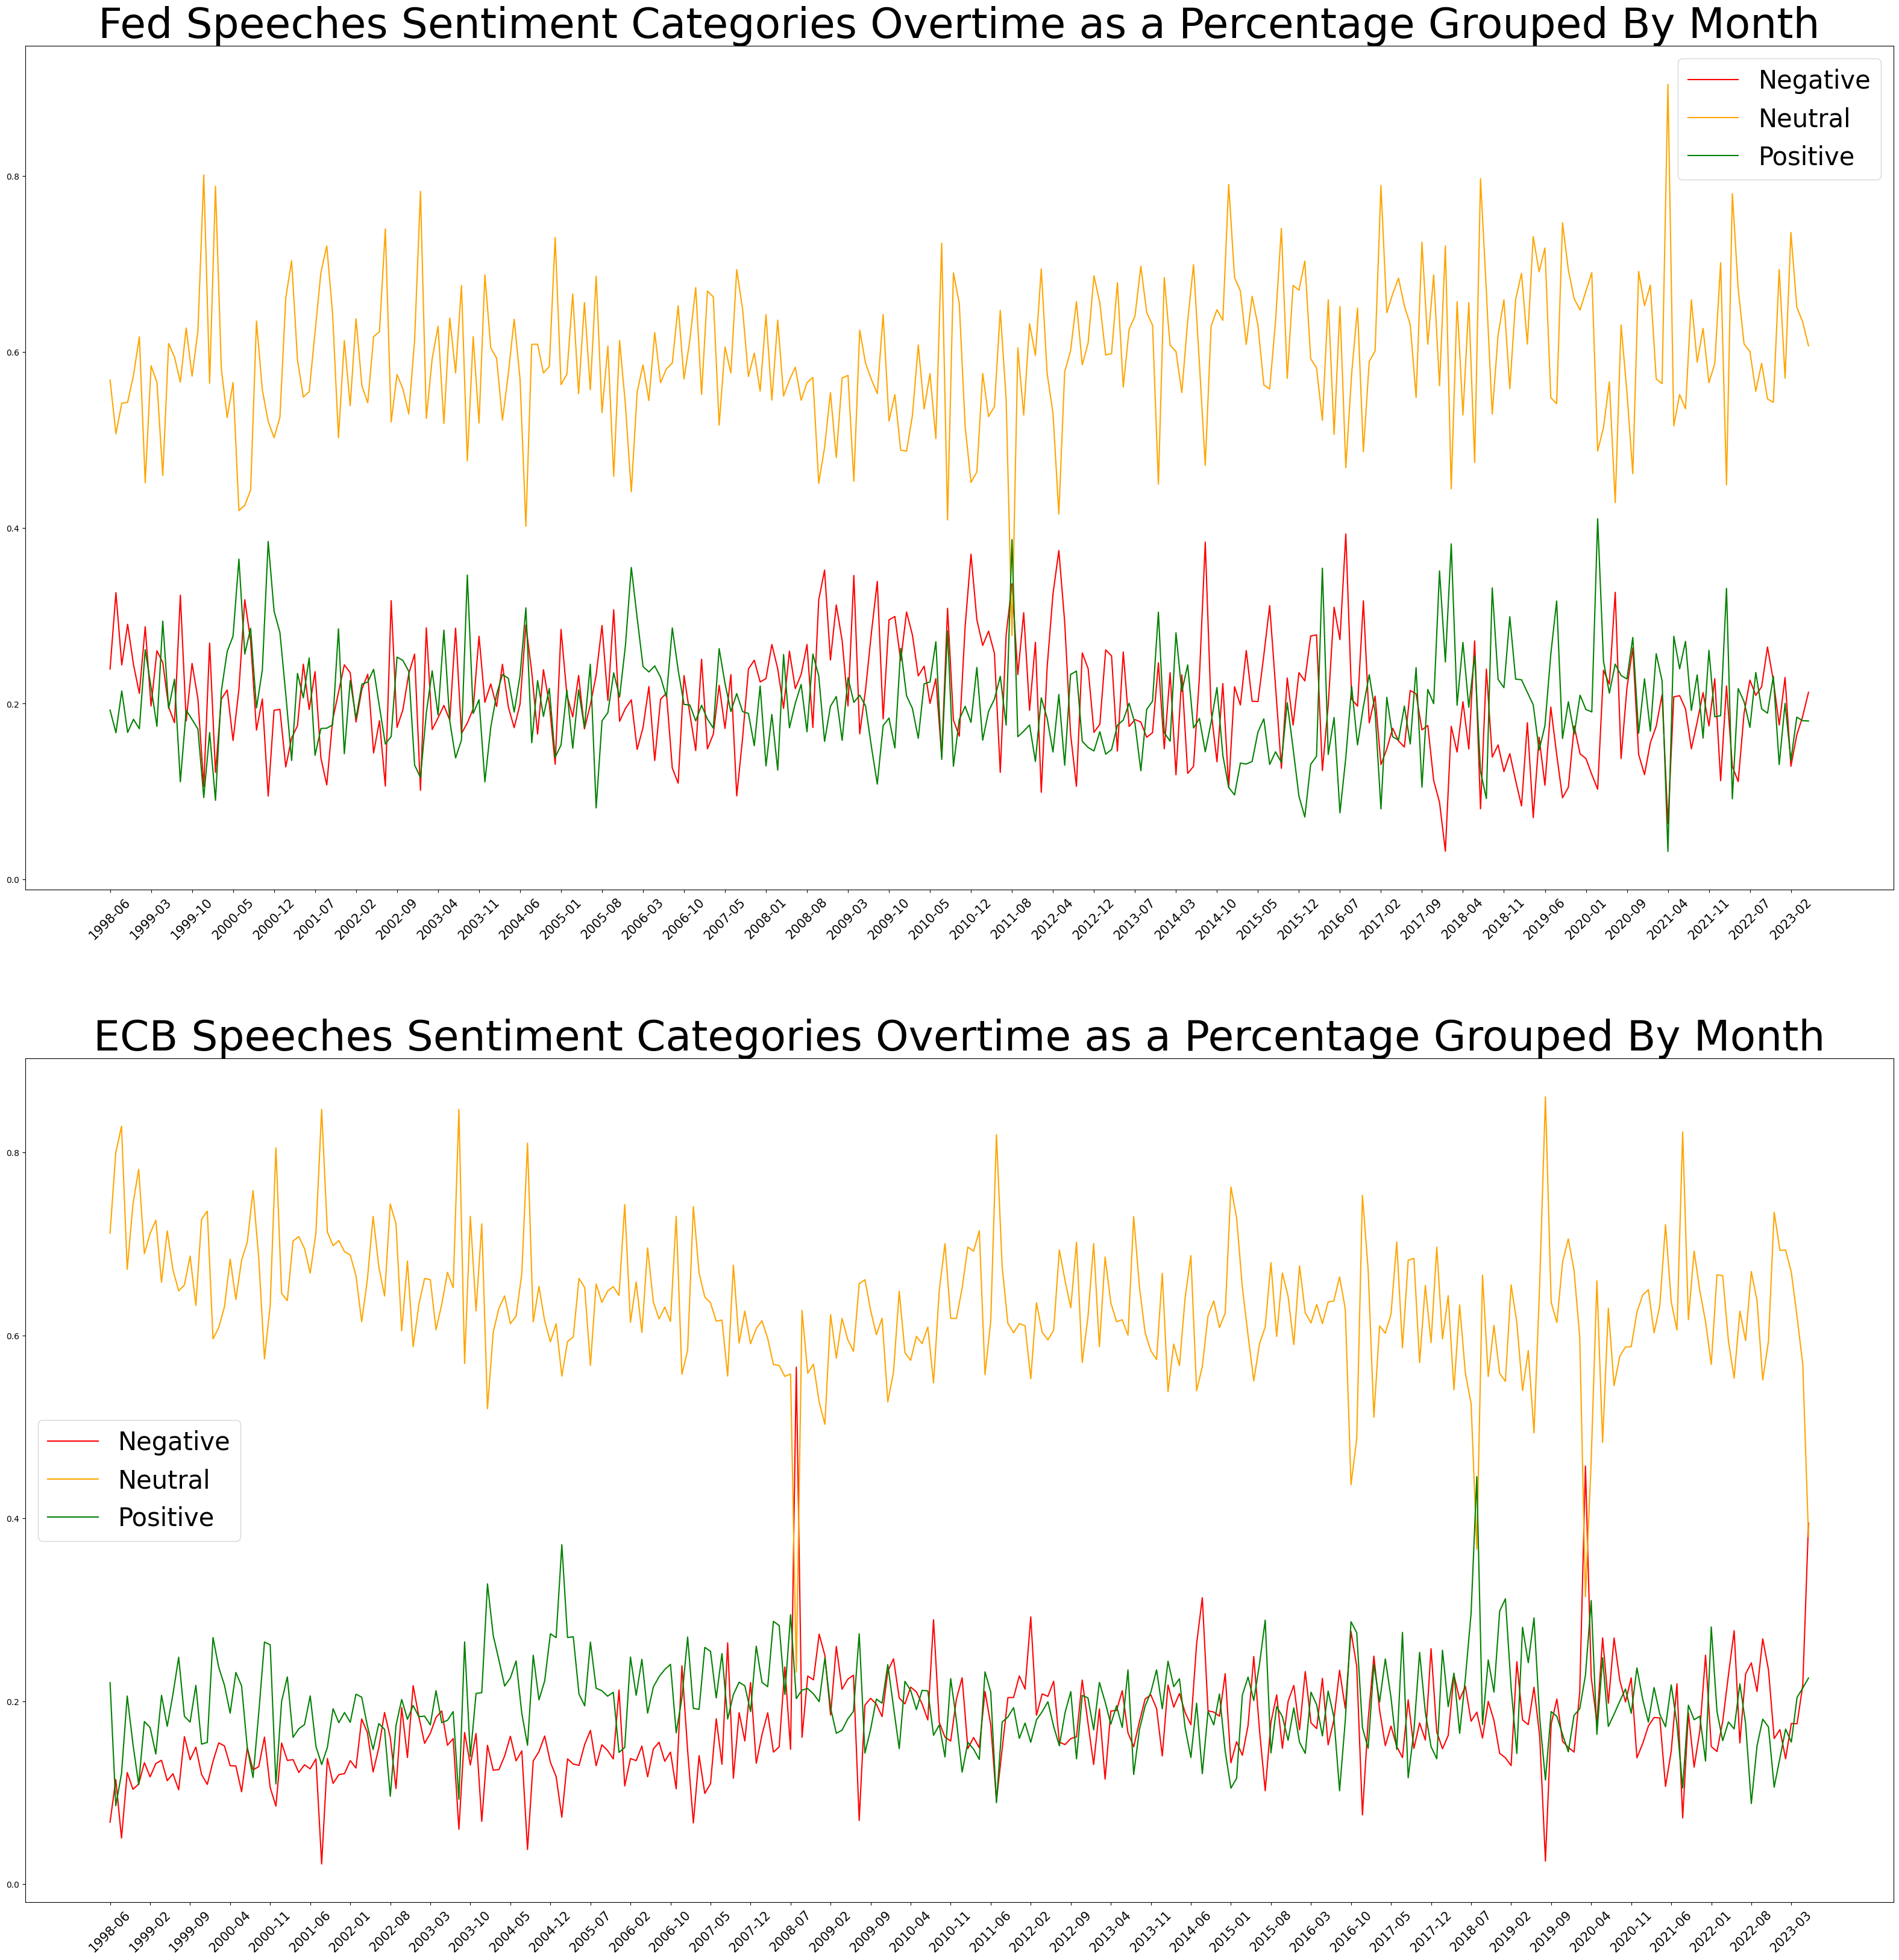

In [139]:
#num_plot = df_num_sent.plot(x='date', y=['neg', 'neu', 'pos'], kind='bar', stacked=True, figsize=(40,20), legend=True, fontsize=20)


# Create a list of x-axis tick positions
num_ticks = 40  # Adjust this number as needed
x_tick_positions_0 = df_num_sent['date'].iloc[::len(df_num_sent) // num_ticks].tolist()
x_tick_positions_1 = df_num_sent_2['date'].iloc[::len(df_num_sent_2) // num_ticks].tolist()

fig, axs = plt.subplots(2, 1, figsize=(40, 40))

axs[0].plot(df_num_sent['date'], df_num_sent['neg'], color='red')
axs[0].plot(df_num_sent['date'], df_num_sent['neu'], color='orange')
axs[0].plot(df_num_sent['date'], df_num_sent['pos'], color='green')

axs[1].plot(df_num_sent_2['date'], df_num_sent_2['neg'], color='red')
axs[1].plot(df_num_sent_2['date'], df_num_sent_2['neu'], color='orange')
axs[1].plot(df_num_sent_2['date'], df_num_sent_2['pos'], color='green')

# Set x-axis ticks for both subplots
axs[0].set_xticks(x_tick_positions_0)
axs[1].set_xticks(x_tick_positions_1)

axs[0].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='x', rotation=45, labelsize=15)


axs[0].set_title(f'{Body} {Model} Sentiment Categories Overtime as a Percentage Grouped By Month', fontsize=50)
axs[1].set_title(f'{Body_2} {Model_2} Sentiment Categories Overtime as a Percentage Grouped By Month', fontsize=50)


axs[0].legend(['Negative', 'Neutral', 'Positive'], fontsize=30)
axs[1].legend(['Negative', 'Neutral', 'Positive'], fontsize=30)

plt.show()

In [140]:
titles_1 = pivot.columns.tolist()
sub_var = [] 

for title in titles_1:
    sub_var.append(df_var[df_var['doc_num'] == title]['sentiment_sd'].values[0])
    
df_sub_var = pd.DataFrame({'doc_num': titles_1, 'sd': sub_var})
var_ts = df_tone.merge(df_sub_var, on='doc_num', how='inner')

print(var_ts.head())
#Convert the date column to a datetime object
var_ts['date'] = pd.to_datetime(var_ts['date'])

#Convert Date to a quarterly period
var_ts['date'] = var_ts['date'].dt.to_period('Q')

var_ts = var_ts[['date', 'sd']]

#Agregate dates to quarterly
var_ts = var_ts.groupby(['date']).agg(['mean', 'median', 'var']).reset_index()
var_ts.columns = ['_'.join(col).strip() for col in var_ts.columns.values]
var_ts['sd_sd'] = var_ts['sd_var']**0.5
var_ts = var_ts.rename(columns={'date_': 'date'})


         date         doc_num  tone   sd
0  1998-06-03  Fed_Speeches_0     0 0.57
1  1998-06-09  Fed_Speeches_1     0 0.57
2  1998-06-18  Fed_Speeches_2     1 0.81
3  1998-07-09  Fed_Speeches_3     1 0.66
4  1998-07-10  Fed_Speeches_4     0 0.68


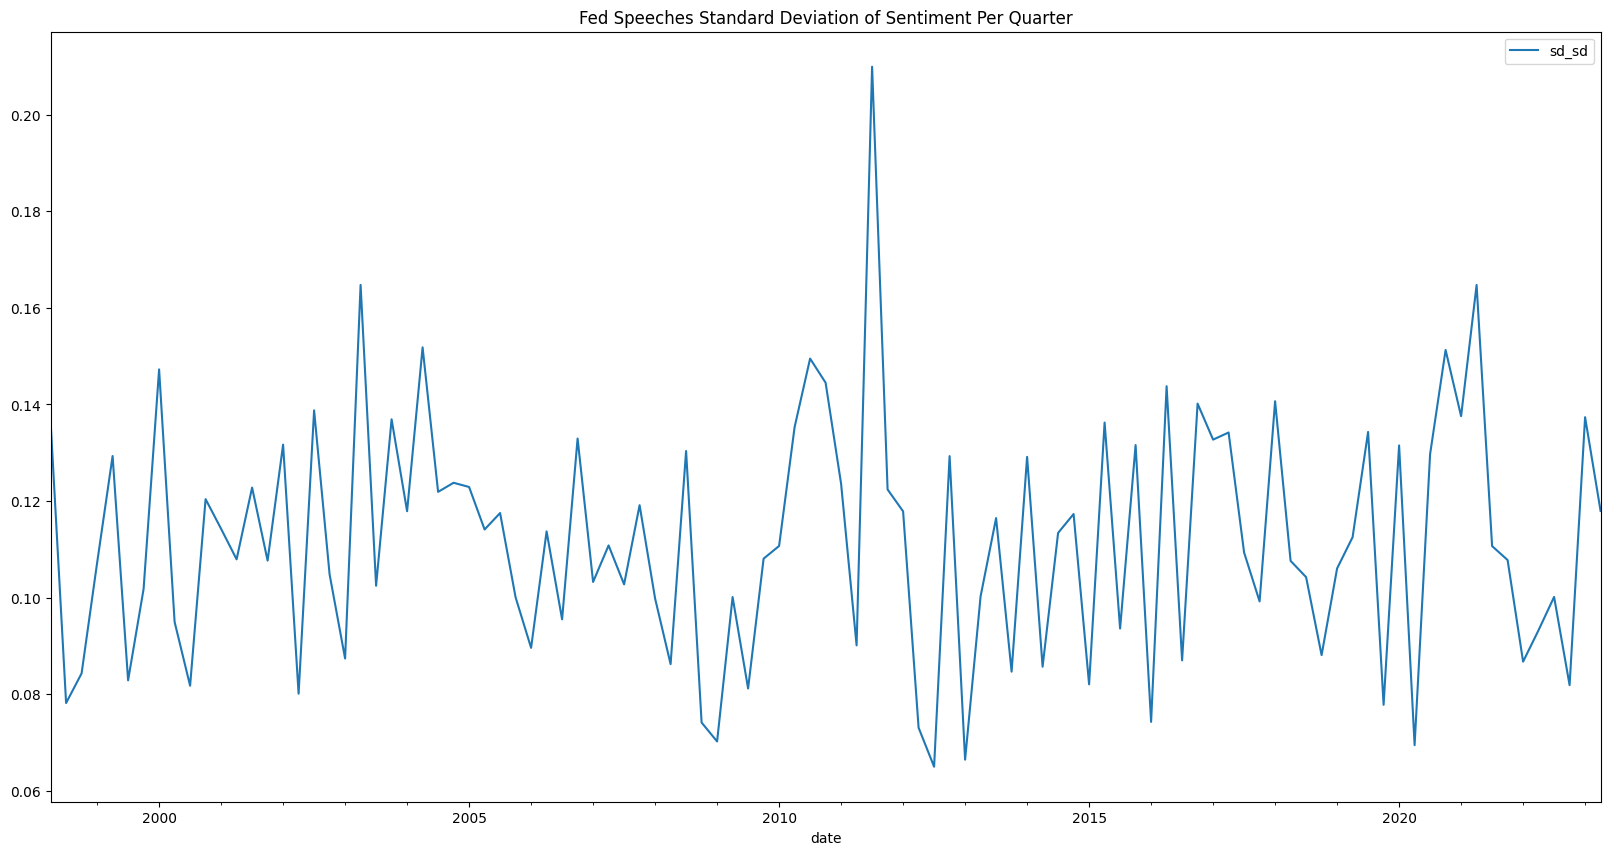

In [141]:
plot = var_ts.plot(x='date', y='sd_sd', figsize=(20,10), title = f'{Body} {Model} Standard Deviation of Sentiment Standard Deviation Per Quarter')


In [142]:
pivot['mean'] = pivot.mean(axis=1)
pivot['var'] = pivot.var(axis=1)
pivot['sd'] = pivot['var']**0.5

window = 15

pivot['rmean'] = pivot['mean'].rolling(window).mean()
pivot['rvar'] = pivot['mean'].rolling(window).var()
pivot['rsd'] = pivot['rvar']**0.5
pivot['ci'] = 1.96 * np.sqrt(pivot['rsd'] / len(pivot['rsd']))

doc_num     Fed_Speeches_0  Fed_Speeches_1  Fed_Speeches_10  Fed_Speeches_100  \
dup_number                                                                      
1                     1.00            0.00             1.00              0.00   
2                     0.00            0.00             0.00              0.00   
3                     0.00            0.00             1.00              1.00   
4                     0.00            0.00            -1.00              1.00   
5                     0.00            0.00             0.00              0.00   

doc_num     Fed_Speeches_1000  Fed_Speeches_1001  Fed_Speeches_1002  \
dup_number                                                            
1                        0.00               0.00               0.00   
2                        0.00               0.00               0.00   
3                        0.00               1.00              -1.00   
4                        0.00              -1.00              -1.00   
5     

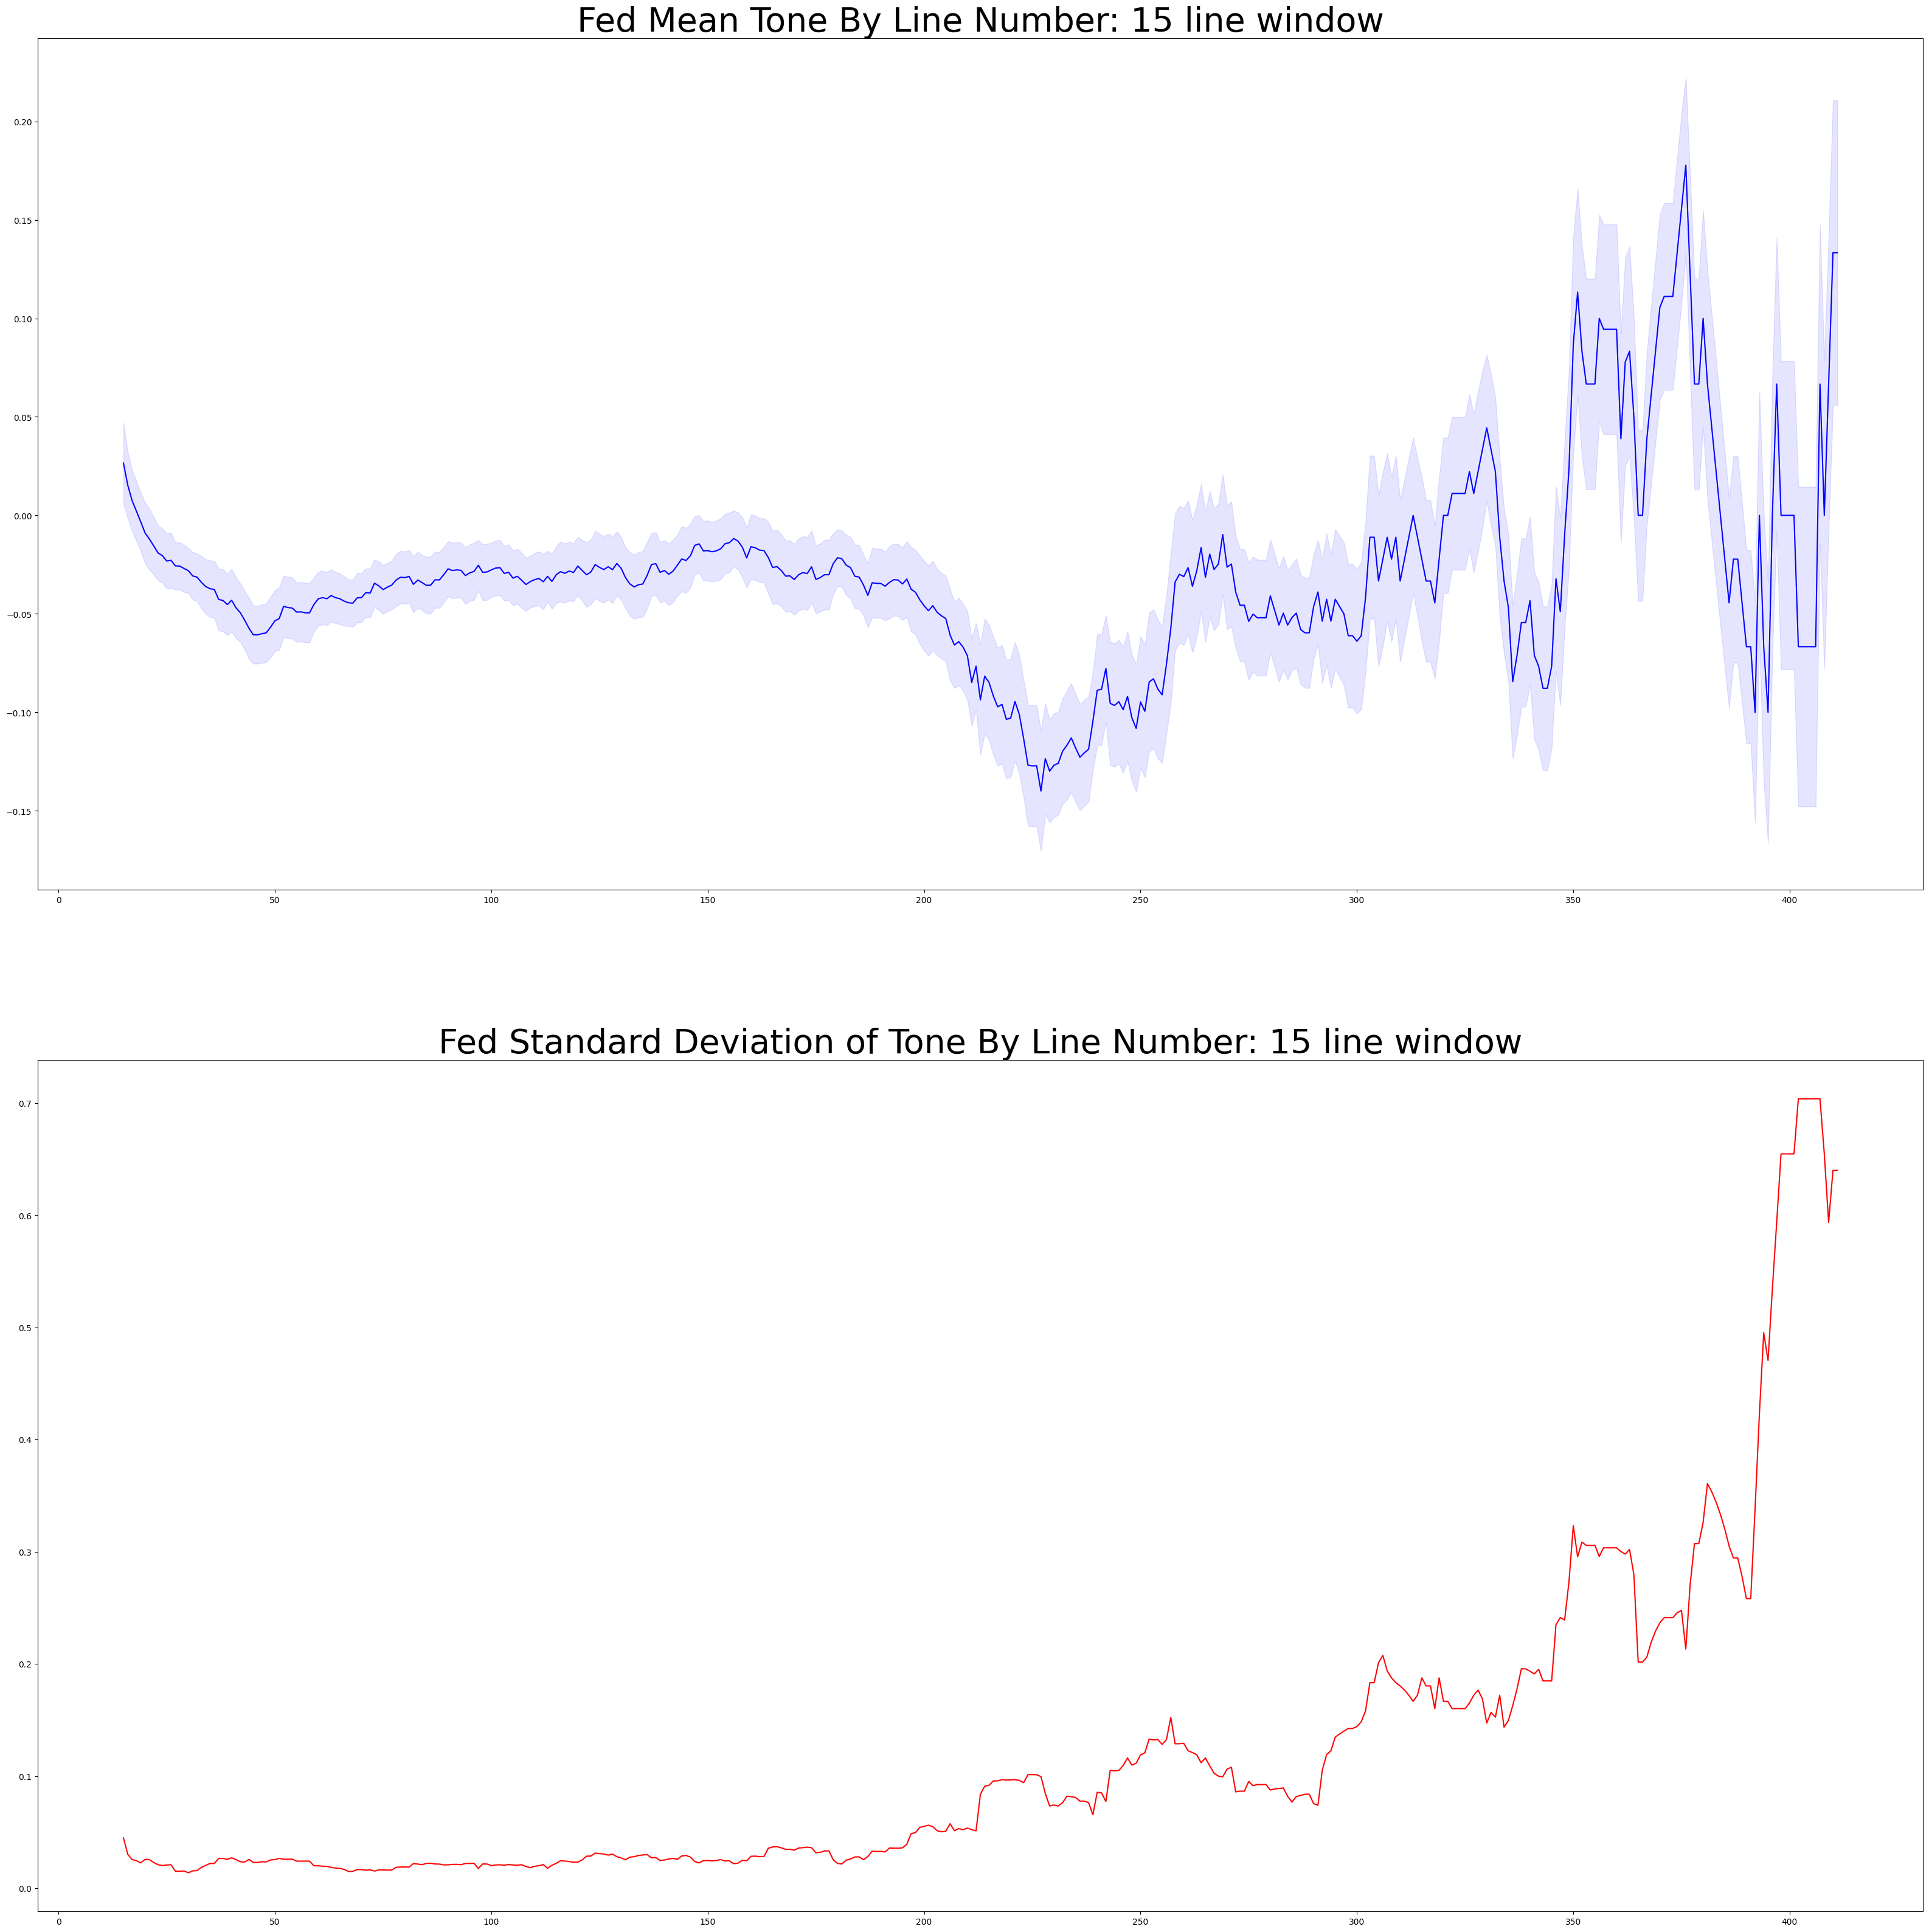

In [143]:
print(pivot.head())


# Create a list of x-axis tick positions
# num_ticks = 200  # Adjust this number as needed
# x_tick_positions_0 = pivot['date'].iloc[::len(df) // num_ticks].tolist()
# x_tick_positions_1 = pivot['date'].iloc[::len(df) // num_ticks].tolist()

fig, axs = plt.subplots(2, 1, figsize=(40, 40))
axs[0].plot(pivot['rmean'], color='blue', label='mean')
axs[0].fill_between(pivot.index, pivot['rmean'] - pivot['ci'], pivot['rmean'] + pivot['ci'], color='b', alpha=.1)

axs[1].plot(pivot['rsd'], color='red', label='var')

axs[0].set_title(f'{Body} Mean Tone By Line Number: {window} line window', fontsize=40)
axs[1].set_title(f'{Body} Standard Deviation of Tone By Line Number: {window} line window', fontsize=40)

plt.show()

In [144]:
df_sent_2 = df_sent_2[['doc_num', 'sentiment']]
df_sent_2['dup_number'] = df_sent_2.groupby(['doc_num']).cumcount()+1


print(df_sent_2.head())
#pivot = df_sent.pivot(index='title', columns='dup_number', values ='sentiment')
#pivot_2 = pd.pivot_table(df_sent_2, index='title', columns='dup_number', values ='sentiment', fill_value=0)
pivot_2 = pd.pivot_table(df_sent_2, index='dup_number', columns='doc_num', values ='sentiment', fill_value=None)


  doc_num  sentiment  dup_number
0    ECB1          0           1
1    ECB1          0           2
2    ECB1          0           3
3    ECB1          1           4
4    ECB1          1           5


In [145]:
pivot_2['mean'] = pivot_2.mean(axis=1)
pivot_2['var'] = pivot_2.var(axis=1)

window = 250

pivot_2['rmean'] = pivot_2['mean'].rolling(window).mean()
pivot_2['rvar'] = pivot_2['mean'].rolling(window).var()
pivot_2['ci'] = 1.96 * np.sqrt(pivot_2['rvar'] / len(pivot_2['rvar']))

#print(df_group.groupby('period')[['tone', 'rvar']].describe())

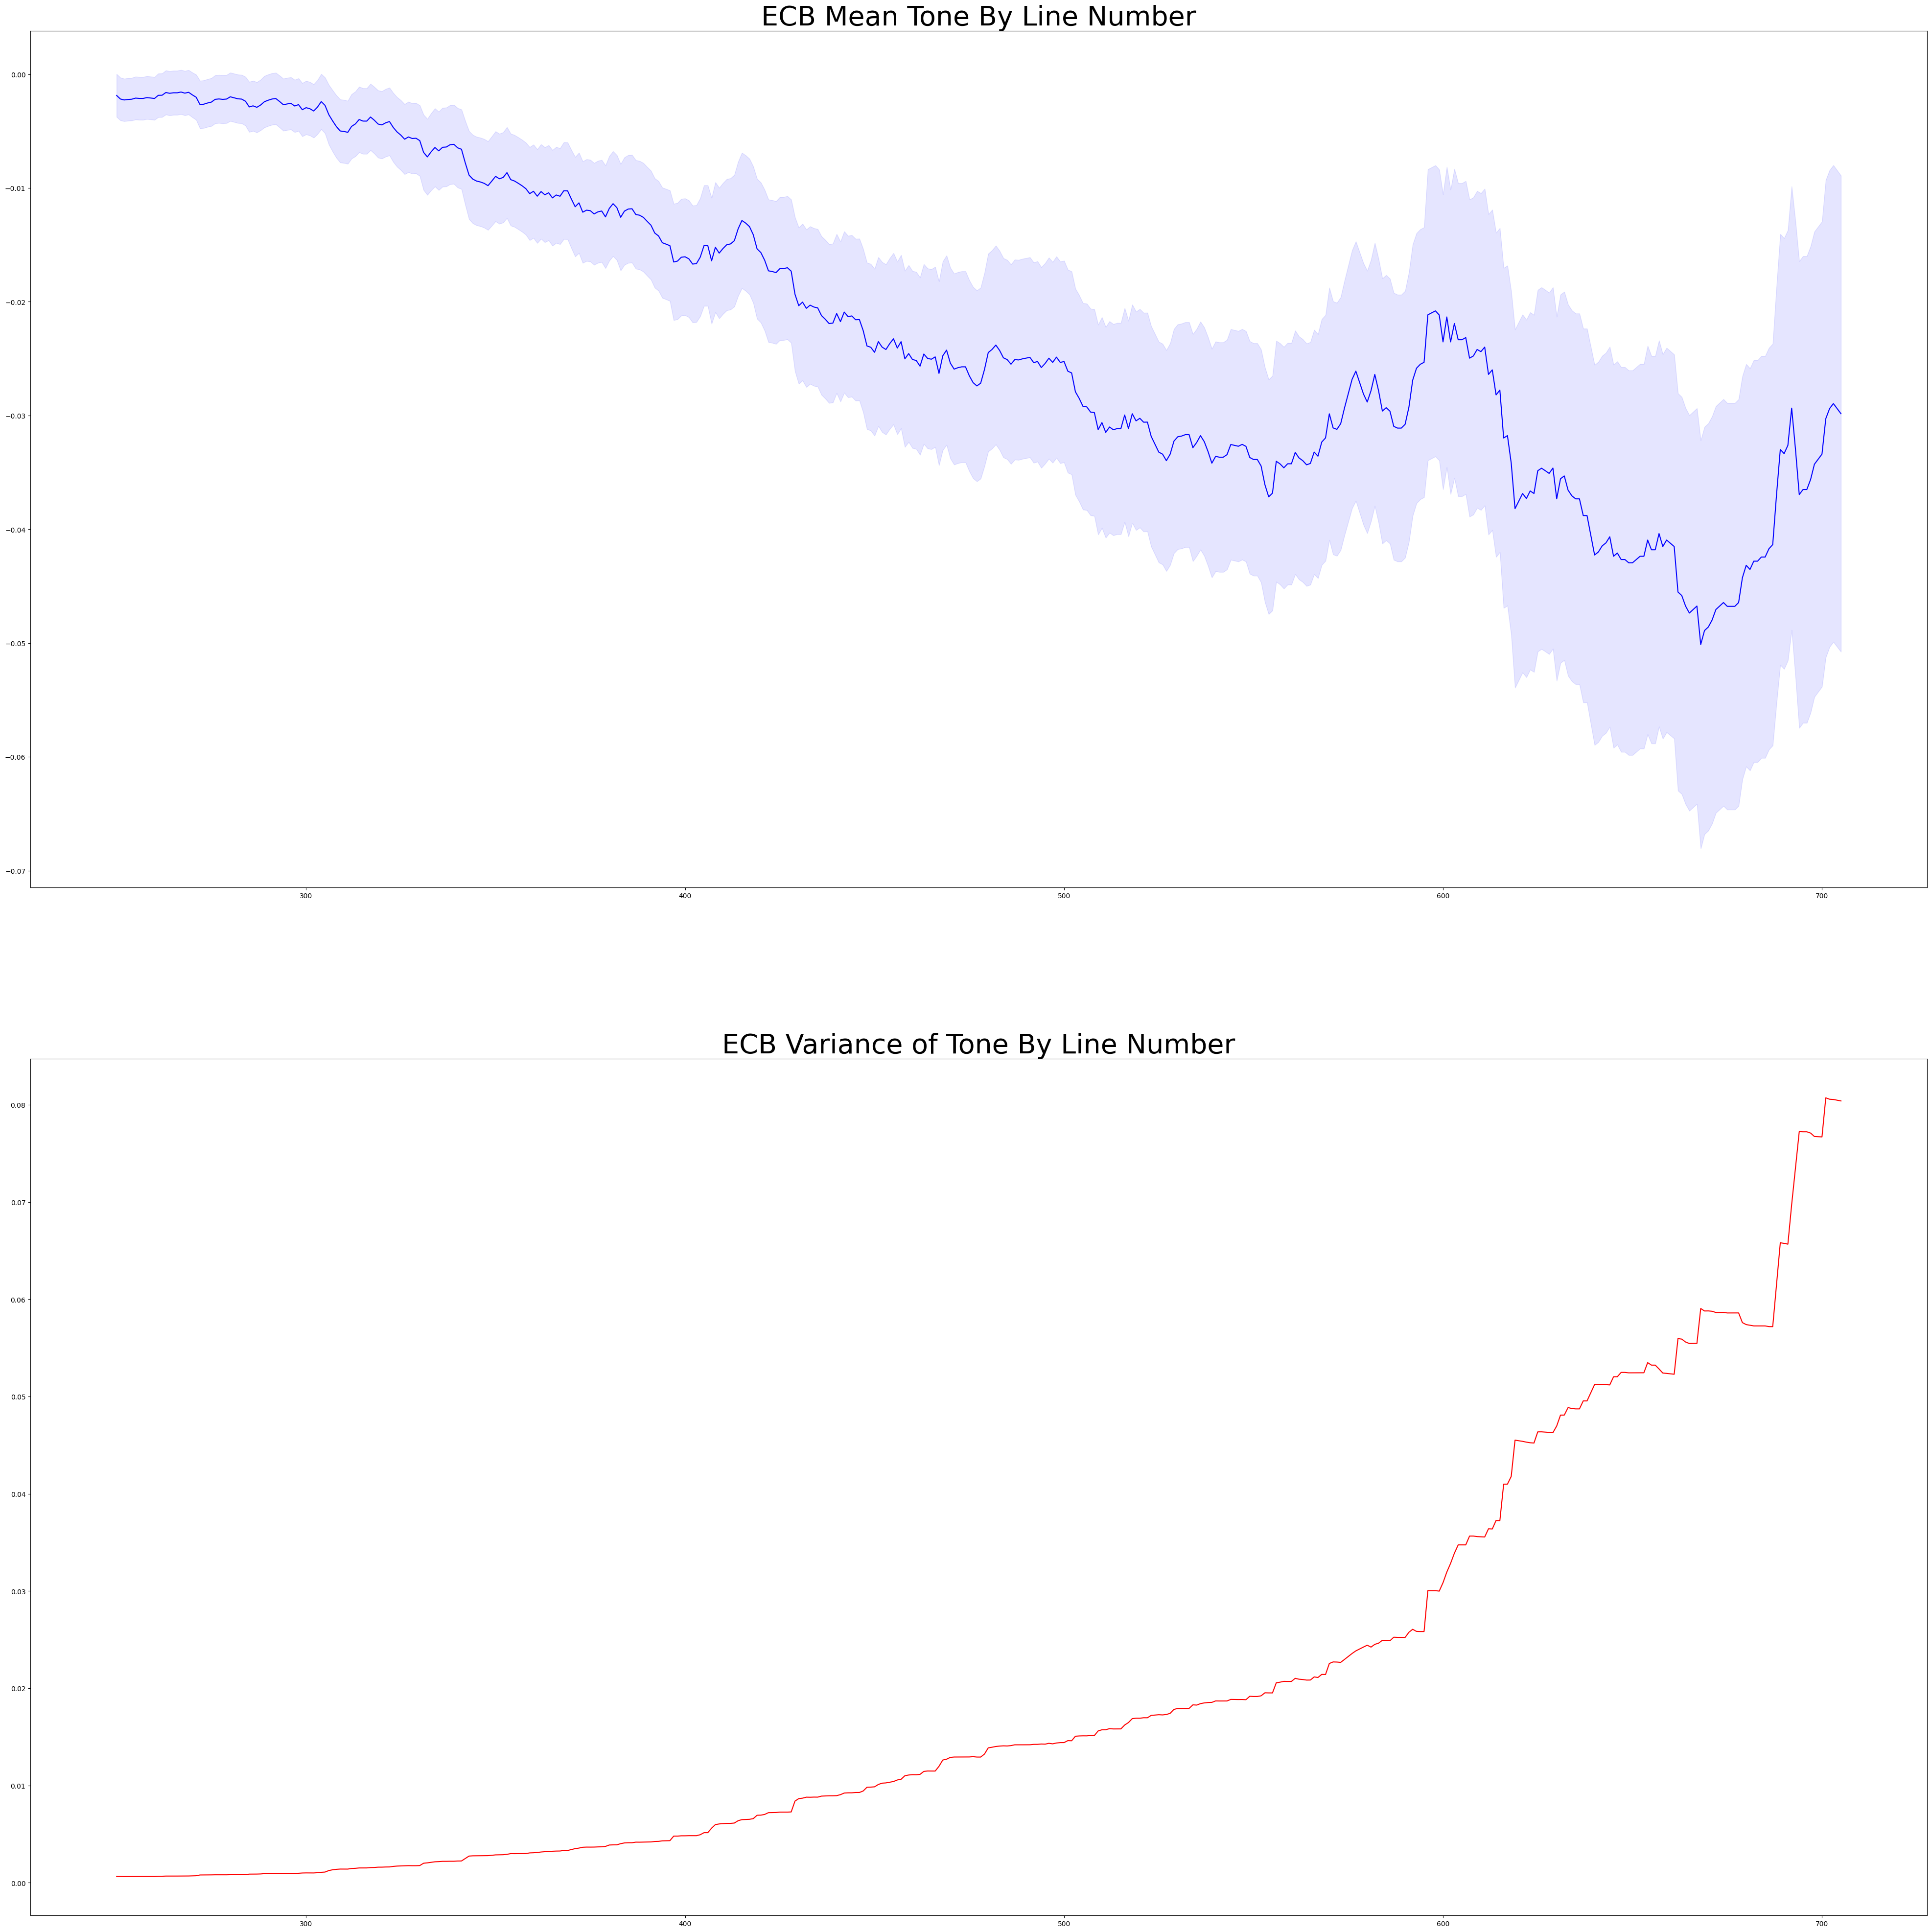

In [146]:
# pivot_2['mean'] = pivot_2.mean(axis=1)
# pivot_2['var'] = pivot_2.var(axis=1)


# Create a list of x-axis tick positions
# num_ticks = 200  # Adjust this number as needed
# x_tick_positions_0 = pivot['date'].iloc[::len(df) // num_ticks].tolist()
# x_tick_positions_1 = pivot['date'].iloc[::len(df) // num_ticks].tolist()

pivot_2['ci'] = 1.96 * np.sqrt(pivot_2['rvar'] / len(pivot_2['rvar']))

fig, axs = plt.subplots(2, 1, figsize=(50, 50))
axs[0].plot(pivot_2['rmean'], color='blue', label='mean')
axs[0].fill_between(pivot_2.index, pivot_2['rmean'] - pivot_2['ci'], pivot_2['rmean'] + pivot_2['ci'], color='b', alpha=.1)


axs[1].plot(pivot_2['rvar'], color='red', label='rvar')

axs[0].set_title(f'{Body_2} Mean Tone By Line Number', fontsize=40)
axs[1].set_title(f'{Body_2} Variance of Tone By Line Number', fontsize=40)

plt.show()

In [147]:
df_group = df.copy(deep=True)
meta_temp = df.copy(deep=True)

df_group_2 = df_2.copy(deep=True)
meta_temp_2 = df_2.copy(deep=True)

In [148]:
tdate = df_group['date'].tolist()

dout = []
for date in tdate:

    if '1998-06-1' <= date < '2000-06-01':
        dout.append([date, 1])
    
    if '2000-06-1' <= date < '2002-06-01':
        dout.append([date, 2])
        
    if '2002-06-1' <= date < '2004-06-01':
        dout.append([date, 3])
    
    if '2004-06-1' <= date < '2006-06-01':
        dout.append([date, 4])
        
    if '2006-06-1' <= date < '2008-06-01':
        dout.append([date, 5])
        
    if '2008-06-1' <= date < '2010-06-01':
        dout.append([date, 6])
        
    if '2010-06-1' <= date < '2012-06-01':
        dout.append([date, 7])
        
    if '2012-06-1' <= date < '2014-06-01':
        dout.append([date, 8])
        
    if '2014-06-1' <= date < '2016-06-01':
        dout.append([date, 9])
        
    if '2016-06-1' <= date < '2018-06-01':
        dout.append([date, 10])
        
    if '2018-06-1' <= date < '2020-06-01':
        dout.append([date, 11])
        
    if '2020-06-1' <= date < '2022-06-01':
        dout.append([date, 12])
        
    if '2022-06-1' <= date < '2024-06-01':
        dout.append([date, 13])
        
print(dout)
df_dates = pd.DataFrame(dout, columns=['date', 'period'])
df_group = df_group.merge(df_dates, on='date', how='inner')
df_group = df_group.drop_duplicates()

df_group = df_group.sort_values(by=['period', 'date'], ascending=True)
print(df_group.head())
    

[['1998-06-18', 1], ['1998-07-09', 1], ['1998-07-10', 1], ['1998-07-20', 1], ['1998-09-04', 1], ['1998-09-15', 1], ['1998-09-17', 1], ['1998-09-18', 1], ['1998-09-28', 1], ['1998-09-29', 1], ['1998-10-05', 1], ['1998-10-14', 1], ['1998-10-16', 1], ['1998-10-22', 1], ['1998-10-22', 1], ['1998-10-22', 1], ['1998-10-27', 1], ['1998-10-29', 1], ['1998-11-05', 1], ['1998-11-06', 1], ['1998-11-12', 1], ['1999-01-03', 1], ['1999-01-04', 1], ['1999-01-11', 1], ['1999-01-15', 1], ['1999-01-21', 1], ['1999-02-11', 1], ['1999-02-16', 1], ['1999-02-24', 1], ['1999-02-25', 1], ['1999-02-25', 1], ['1999-03-01', 1], ['1999-03-03', 1], ['1999-03-08', 1], ['1999-03-08', 1], ['1999-03-09', 1], ['1999-03-10', 1], ['1999-03-12', 1], ['1999-03-16', 1], ['1999-03-16', 1], ['1999-03-19', 1], ['1999-03-25', 1], ['1999-04-06', 1], ['1999-04-13', 1], ['1999-04-14', 1], ['1999-04-16', 1], ['1999-04-22', 1], ['1999-04-22', 1], ['1999-04-26', 1], ['1999-04-29', 1], ['1999-05-06', 1], ['1999-05-13', 1], ['1999-05-1

In [149]:
tdate_2 = df_group_2['date'].tolist()

dout_2 = []
for date in tdate_2:

    if '1998-06-01' <= date < '2000-06-01':
        dout_2.append([date, 1])
    
    if '2000-06-01' <= date < '2002-06-01':
        dout_2.append([date, 2])
        
    if '2002-06-01' <= date < '2004-06-01':
        dout_2.append([date, 3])
    
    if '2004-06-01' <= date < '2006-06-01':
        dout_2.append([date, 4])
        
    if '2006-06-01' <= date < '2008-06-01':
        dout_2.append([date, 5])
        
    if '2008-06-01' <= date < '2010-06-01':
        dout_2.append([date, 6])
        
    if '2010-06-01' <= date < '2012-06-01':
        dout_2.append([date, 7])
        
    if '2012-06-01' <= date < '2014-06-01':
        dout_2.append([date, 8])
        
    if '2014-06-01' <= date < '2016-06-01':
        dout_2.append([date, 9])
        
    if '2016-06-01' <= date < '2018-06-01':
        dout_2.append([date, 10])
        
    if '2018-06-01' <= date < '2020-06-01':
        dout_2.append([date, 11])
        
    if '2020-06-01' <= date < '2022-06-01':
        dout_2.append([date, 12])
        
    if '2022-06-01' <= date < '2024-06-01':
        dout_2.append([date, 13])
        
print(dout_2)
df_dates_2 = pd.DataFrame(dout_2, columns=['date', 'period'])
df_group_2 = df_group_2.merge(df_dates_2, on='date', how='inner')
df_group_2 = df_group_2.drop_duplicates()

df_group_2 = df_group_2.sort_values(by=['period', 'date'], ascending=True)
print(df_group_2.head())
    

[['2023-06-01', 13], ['2023-06-01', 13], ['2023-05-25', 13], ['2023-05-24', 13], ['2023-05-23', 13], ['2023-05-19', 13], ['2023-05-17', 13], ['2023-05-16', 13], ['2023-05-05', 13], ['2023-04-24', 13], ['2023-04-24', 13], ['2023-04-21', 13], ['2023-04-19', 13], ['2023-04-17', 13], ['2023-04-14', 13], ['2023-04-01', 13], ['2023-03-27', 13], ['2023-03-27', 13], ['2023-03-22', 13], ['2023-03-22', 13], ['2023-03-20', 13], ['2023-03-08', 13], ['2023-03-08', 13], ['2023-03-06', 13], ['2023-03-02', 13], ['2023-02-16', 13], ['2023-02-16', 13], ['2023-02-15', 13], ['2023-01-23', 13], ['2023-01-23', 13], ['2023-01-10', 13], ['2022-12-08', 13], ['2022-12-07', 13], ['2022-12-01', 13], ['2022-11-28', 13], ['2022-11-24', 13], ['2022-11-18', 13], ['2022-11-16', 13], ['2022-11-15', 13], ['2022-11-14', 13], ['2022-11-14', 13], ['2022-11-11', 13], ['2022-11-09', 13], ['2022-11-07', 13], ['2022-11-04', 13], ['2022-11-04', 13], ['2022-11-03', 13], ['2022-10-14', 13], ['2022-10-11', 13], ['2022-09-30', 13],

In [150]:
print(df_group.groupby('period')['tone'].describe())

        count  mean  std   min   25%  50%  75%  max
period                                             
1      123.00  0.27 0.65 -1.00  0.00 0.00 1.00 1.00
2      112.00  0.24 0.66 -1.00  0.00 0.00 1.00 1.00
3      173.00  0.13 0.61 -1.00  0.00 0.00 1.00 1.00
4      161.00  0.25 0.58 -1.00  0.00 0.00 1.00 1.00
5      144.00  0.08 0.64 -1.00  0.00 0.00 0.25 1.00
6      116.00 -0.13 0.76 -1.00 -1.00 0.00 0.00 1.00
7       94.00  0.04 0.69 -1.00  0.00 0.00 0.75 1.00
8       92.00  0.09 0.57 -1.00  0.00 0.00 0.00 1.00
9       88.00  0.17 0.55 -1.00  0.00 0.00 0.25 1.00
10     103.00  0.22 0.63 -1.00  0.00 0.00 1.00 1.00
11     121.00  0.32 0.55 -1.00  0.00 0.00 1.00 1.00
12     115.00  0.30 0.61 -1.00  0.00 0.00 1.00 1.00
13      73.00  0.15 0.57 -1.00  0.00 0.00 0.00 1.00


In [151]:
print(df_group_2.groupby('period')['tone'].describe())

        count  mean  std   min  25%  50%  75%  max
period                                            
1      148.00  0.19 0.39  0.00 0.00 0.00 0.00 1.00
2      144.00  0.15 0.37 -1.00 0.00 0.00 0.00 1.00
3      134.00  0.07 0.36 -1.00 0.00 0.00 0.00 1.00
4      172.00  0.15 0.35  0.00 0.00 0.00 0.00 1.00
5      230.00  0.20 0.42 -1.00 0.00 0.00 0.00 1.00
6      239.00  0.08 0.53 -1.00 0.00 0.00 0.00 1.00
7      221.00  0.06 0.40 -1.00 0.00 0.00 0.00 1.00
8      235.00  0.03 0.44 -1.00 0.00 0.00 0.00 1.00
9      202.00 -0.01 0.46 -1.00 0.00 0.00 0.00 1.00
10     271.00  0.13 0.53 -1.00 0.00 0.00 0.00 1.00
11     195.00  0.09 0.57 -1.00 0.00 0.00 0.00 1.00
12     178.00 -0.01 0.48 -1.00 0.00 0.00 0.00 1.00
13      73.00  0.12 0.50 -1.00 0.00 0.00 0.00 1.00


In [152]:
df_group = df_group[['date', 'tone', 'sentiment_mean', 'sentiment_median', 'sentiment_var', 'period']]
df_group_2 = df_group_2[['date', 'tone', 'sentiment_mean', 'sentiment_median', 'sentiment_var', 'period']]

df_group = df_group.groupby('date', as_index = False, dropna=True).mean()
df_group_2 = df_group_2.groupby('date', as_index = False, dropna=True).mean()

In [153]:
window = 50

df_group['rmean'] = df_group['tone'].rolling(window).mean()
df_group['rvar'] = df_group['tone'].rolling(window).var()
df_group['ci'] = 1.96 * np.sqrt(df_group['rvar'] / len(df_group['rvar']))

#print(df_group.groupby('period')[['tone', 'rvar']].describe())

In [154]:
df_group_2['rmean'] = df_group_2['tone'].rolling(window).mean()
df_group_2['rvar'] = df_group_2['tone'].rolling(window).var()
df_group_2['ci'] = 1.96 * np.sqrt(df_group_2['rvar'] / len(df_group_2['rvar']))


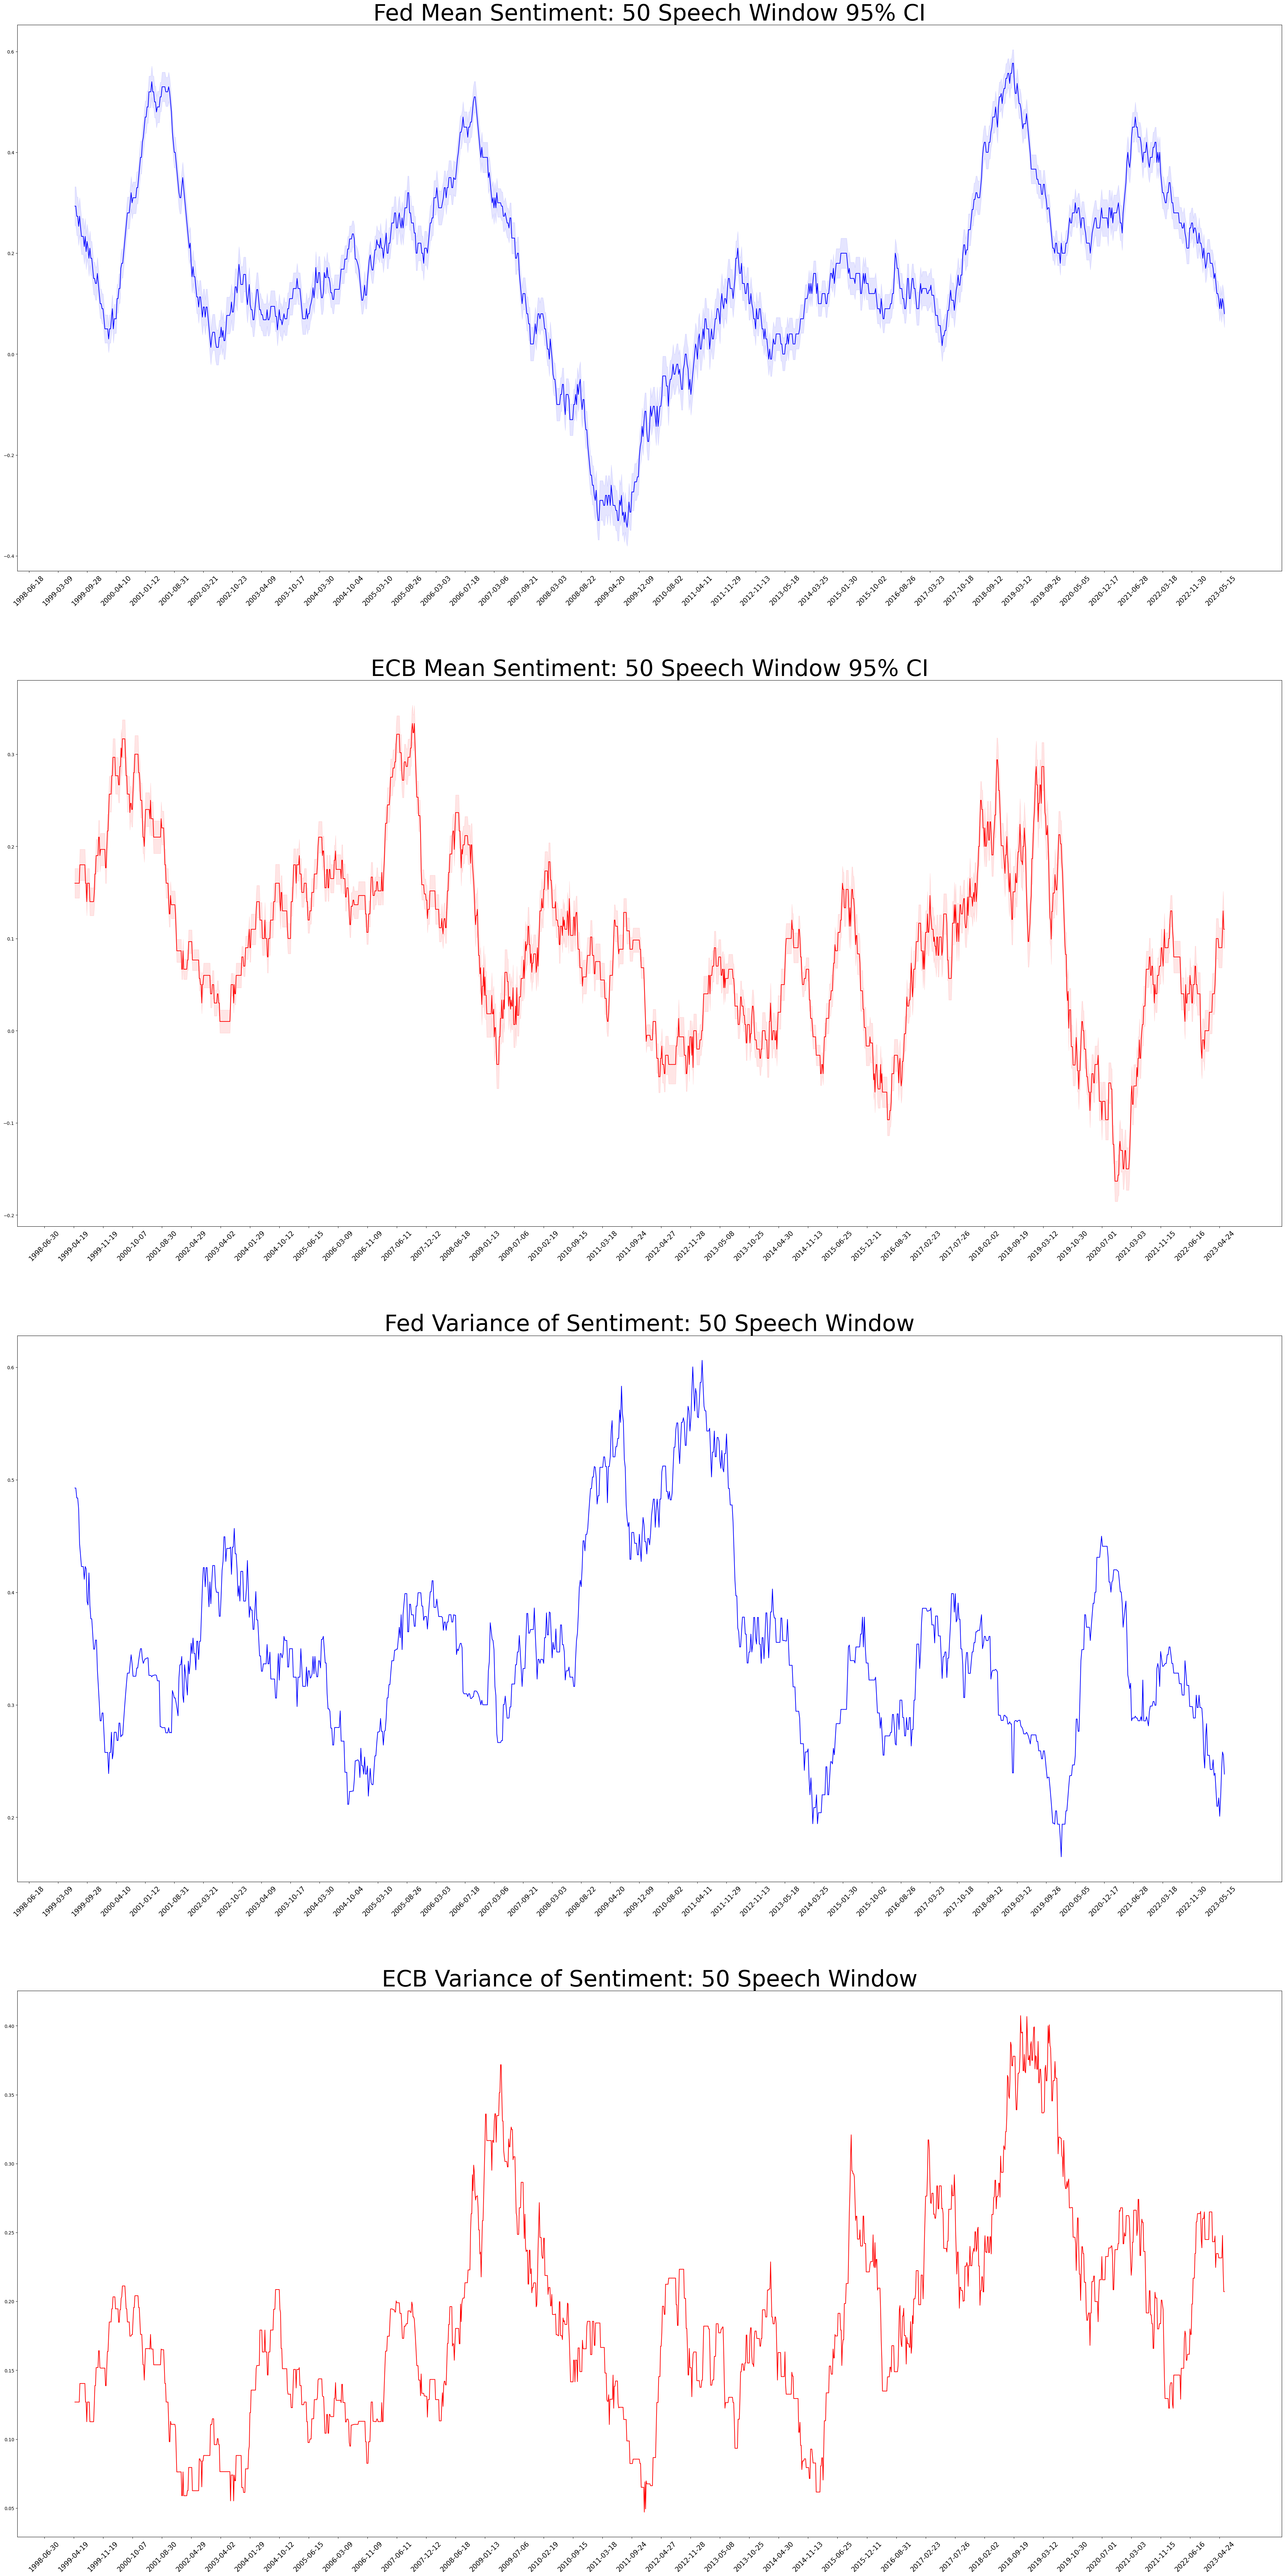

In [155]:

# Create a list of x-axis tick positions
num_ticks = 40  # Adjust this number as needed
x_tick_positions_0 = df_group['date'].iloc[::len(df_group) // num_ticks].tolist()
x_tick_positions_1 = df_group_2['date'].iloc[::len(df_group_2) // num_ticks].tolist()

fig, axs = plt.subplots(4, 1, figsize=(50, 100))

axs[0].plot(df_group['date'], df_group['rmean'], color='blue')
axs[0].fill_between(df_group['date'], df_group['rmean'] - df_group['ci'], df_group['rmean'] + df_group['ci'], color='b', alpha=.1)
axs[2].plot(df_group['date'], df_group['rvar'], color='blue')

axs[1].plot(df_group_2['date'], df_group_2['rmean'], color='red')
axs[1].fill_between(df_group_2['date'], df_group_2['rmean'] - df_group_2['ci'], df_group_2['rmean'] + df_group_2['ci'], color='r', alpha=.1)
axs[3].plot(df_group_2['date'], df_group_2['rvar'], color='red')

# Set x-axis ticks for both subplots
axs[0].set_xticks(x_tick_positions_0)
axs[1].set_xticks(x_tick_positions_1)
axs[2].set_xticks(x_tick_positions_0)
axs[3].set_xticks(x_tick_positions_1)

axs[0].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='x', rotation=45, labelsize=15)
axs[2].tick_params(axis='x', rotation=45, labelsize=15)
axs[3].tick_params(axis='x', rotation=45, labelsize=15)

axs[0].set_title(f'{Body} Mean Sentiment: {window} Speech Window 95% CI', fontsize=50)
axs[1].set_title(f'{Body_2} Mean Sentiment: {window} Speech Window 95% CI', fontsize=50)
axs[2].set_title(f'{Body} Variance of Sentiment: {window} Speech Window', fontsize=50)
axs[3].set_title(f'{Body_2} Variance of Sentiment: {window} Speech Window', fontsize=50)

plt.show()

In [156]:
df_group['date'] = df_group['date'].str[0:7]
df_group_2['date'] = df_group_2['date'].str[0:7]

df_group = df_group.groupby('date', as_index = False, dropna=True).mean()
df_group_2 = df_group_2.groupby('date', as_index = False, dropna=True).mean()


In [157]:
df_merged = df_group.merge(df_group_2, on='date', how='inner', suffixes=(f'_{Body}{Model}', f'_{Body_2}{Model_2}'))
df_merged = df_merged.drop_duplicates()
df_merged['diff'] = df_merged[f'tone_{Body}{Model}'] - df_merged[f'tone_{Body_2}{Model_2}']

print(df_merged.head())
print(len(df_merged))

      date  tone_FedSpeeches  sentiment_mean_FedSpeeches  \
0  1998-06              1.00                       -0.10   
1  1998-07              0.67                       -0.16   
2  1998-09              0.50                       -0.03   
3  1998-10             -0.06                       -0.13   
4  1998-11              0.67                       -0.06   

   sentiment_median_FedSpeeches  sentiment_var_FedSpeeches  \
0                          0.00                       0.65   
1                          0.00                       0.46   
2                          0.00                       0.46   
3                         -0.06                       0.42   
4                          0.00                       0.42   

   period_FedSpeeches  rmean_FedSpeeches  rvar_FedSpeeches  ci_FedSpeeches  \
0                1.00                NaN               NaN             NaN   
1                1.00                NaN               NaN             NaN   
2                1.00           

In [158]:
#df_merged.to_csv(f"{Sentiment_models}/{Body}_{Model}_vs_{Body_2}_{Model_2}_advanced_sentiment_texts.csv", index=False)

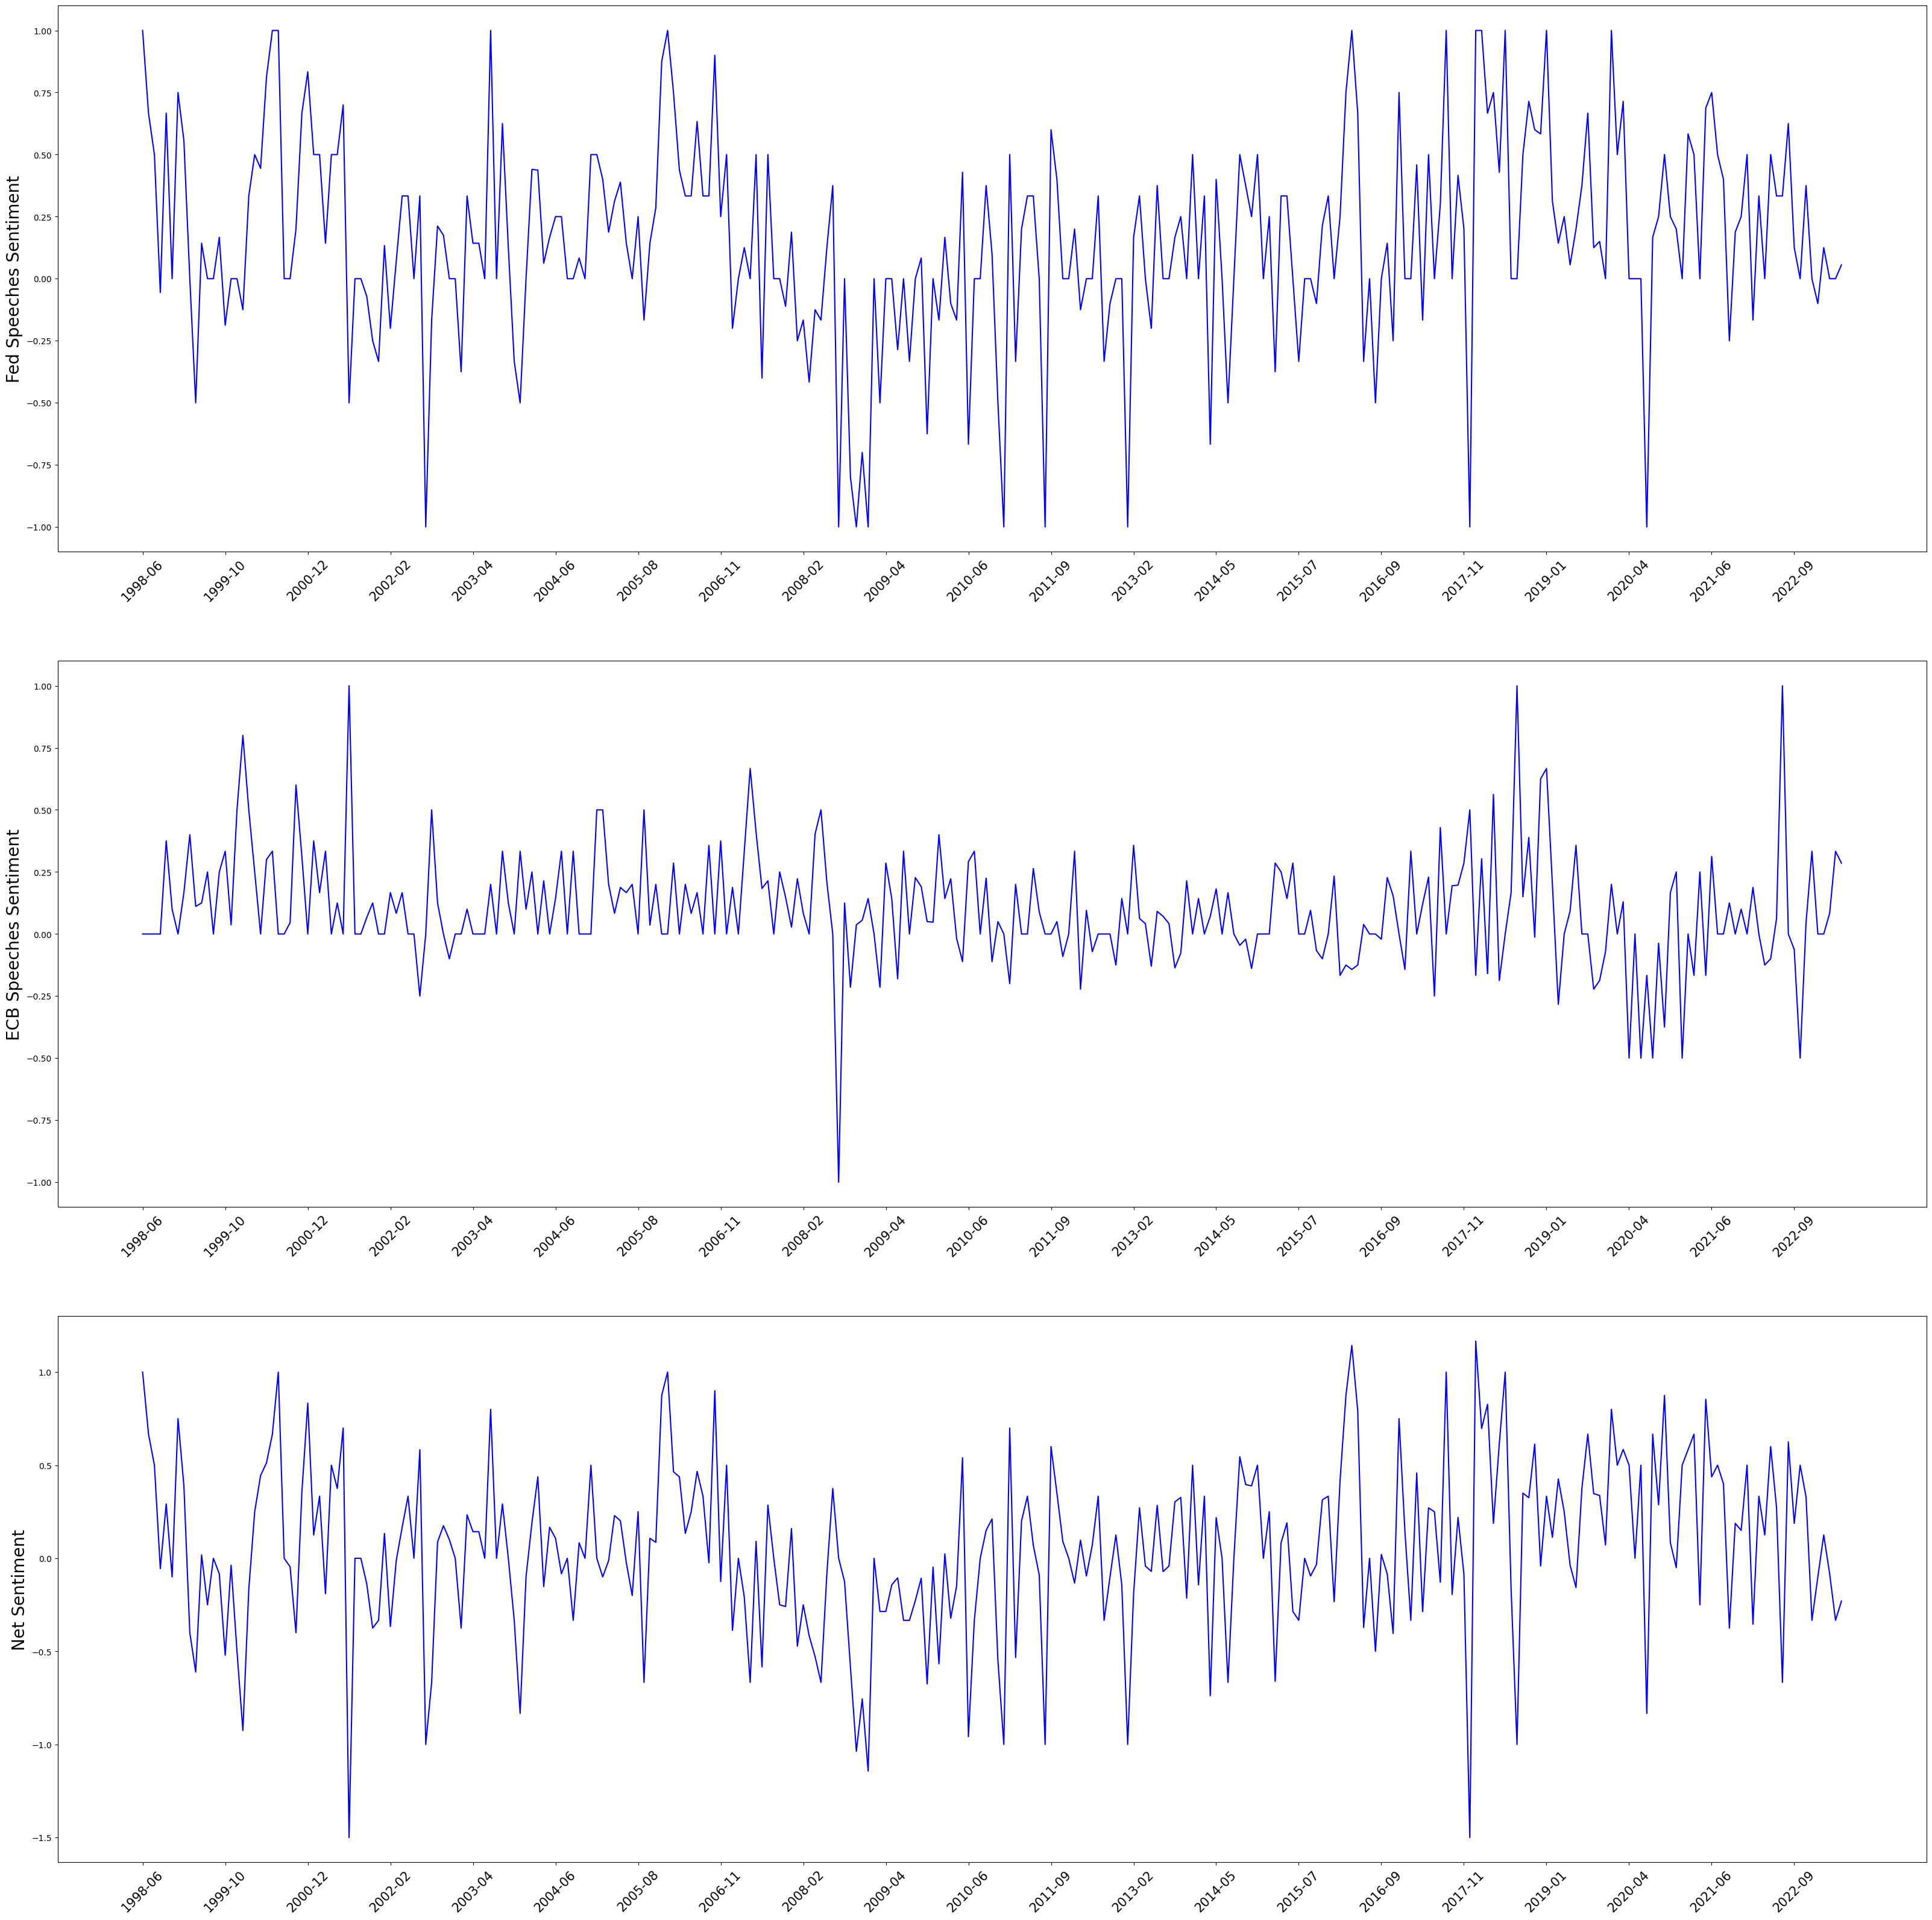

In [159]:

# Create a list of x-axis tick positions
num_ticks = 20  # Adjust this number as needed
x_tick_positions = df_merged['date'].iloc[::len(df_merged) // num_ticks].tolist()

fig, axs = plt.subplots(3, 1, figsize=(40, 40))

axs[0].plot(df_merged['date'], df_merged[f'tone_{Body}{Model}'], color='blue', label='Tone')
axs[1].plot(df_merged['date'], df_merged[f'tone_{Body_2}{Model_2}'], color='blue', label='Tone')
axs[2].plot(df_merged['date'], df_merged['diff'], color='blue', label='Tone')

# Set x-axis ticks for both subplots
axs[0].set_xticks(x_tick_positions)
axs[1].set_xticks(x_tick_positions)
axs[2].set_xticks(x_tick_positions)

axs[0].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='x', rotation=45, labelsize=15)
axs[2].tick_params(axis='x', rotation=45, labelsize=15)

#axs[0].set_yticks(np.arange(-1, 1, .1))
#axs[1].set_yticks(np.arange(-1, 1, .1))
#axs[2].set_yticks(np.arange(-1, 1, .1))

axs[0].set_ylabel(f'{Body} {Model} Sentiment', fontsize=20)
axs[1].set_ylabel(f'{Body_2} {Model_2} Sentiment', fontsize=20)
axs[2].set_ylabel(f'Net Sentiment', fontsize=20)

plt.show()


KeyError: 'Fed_tone'

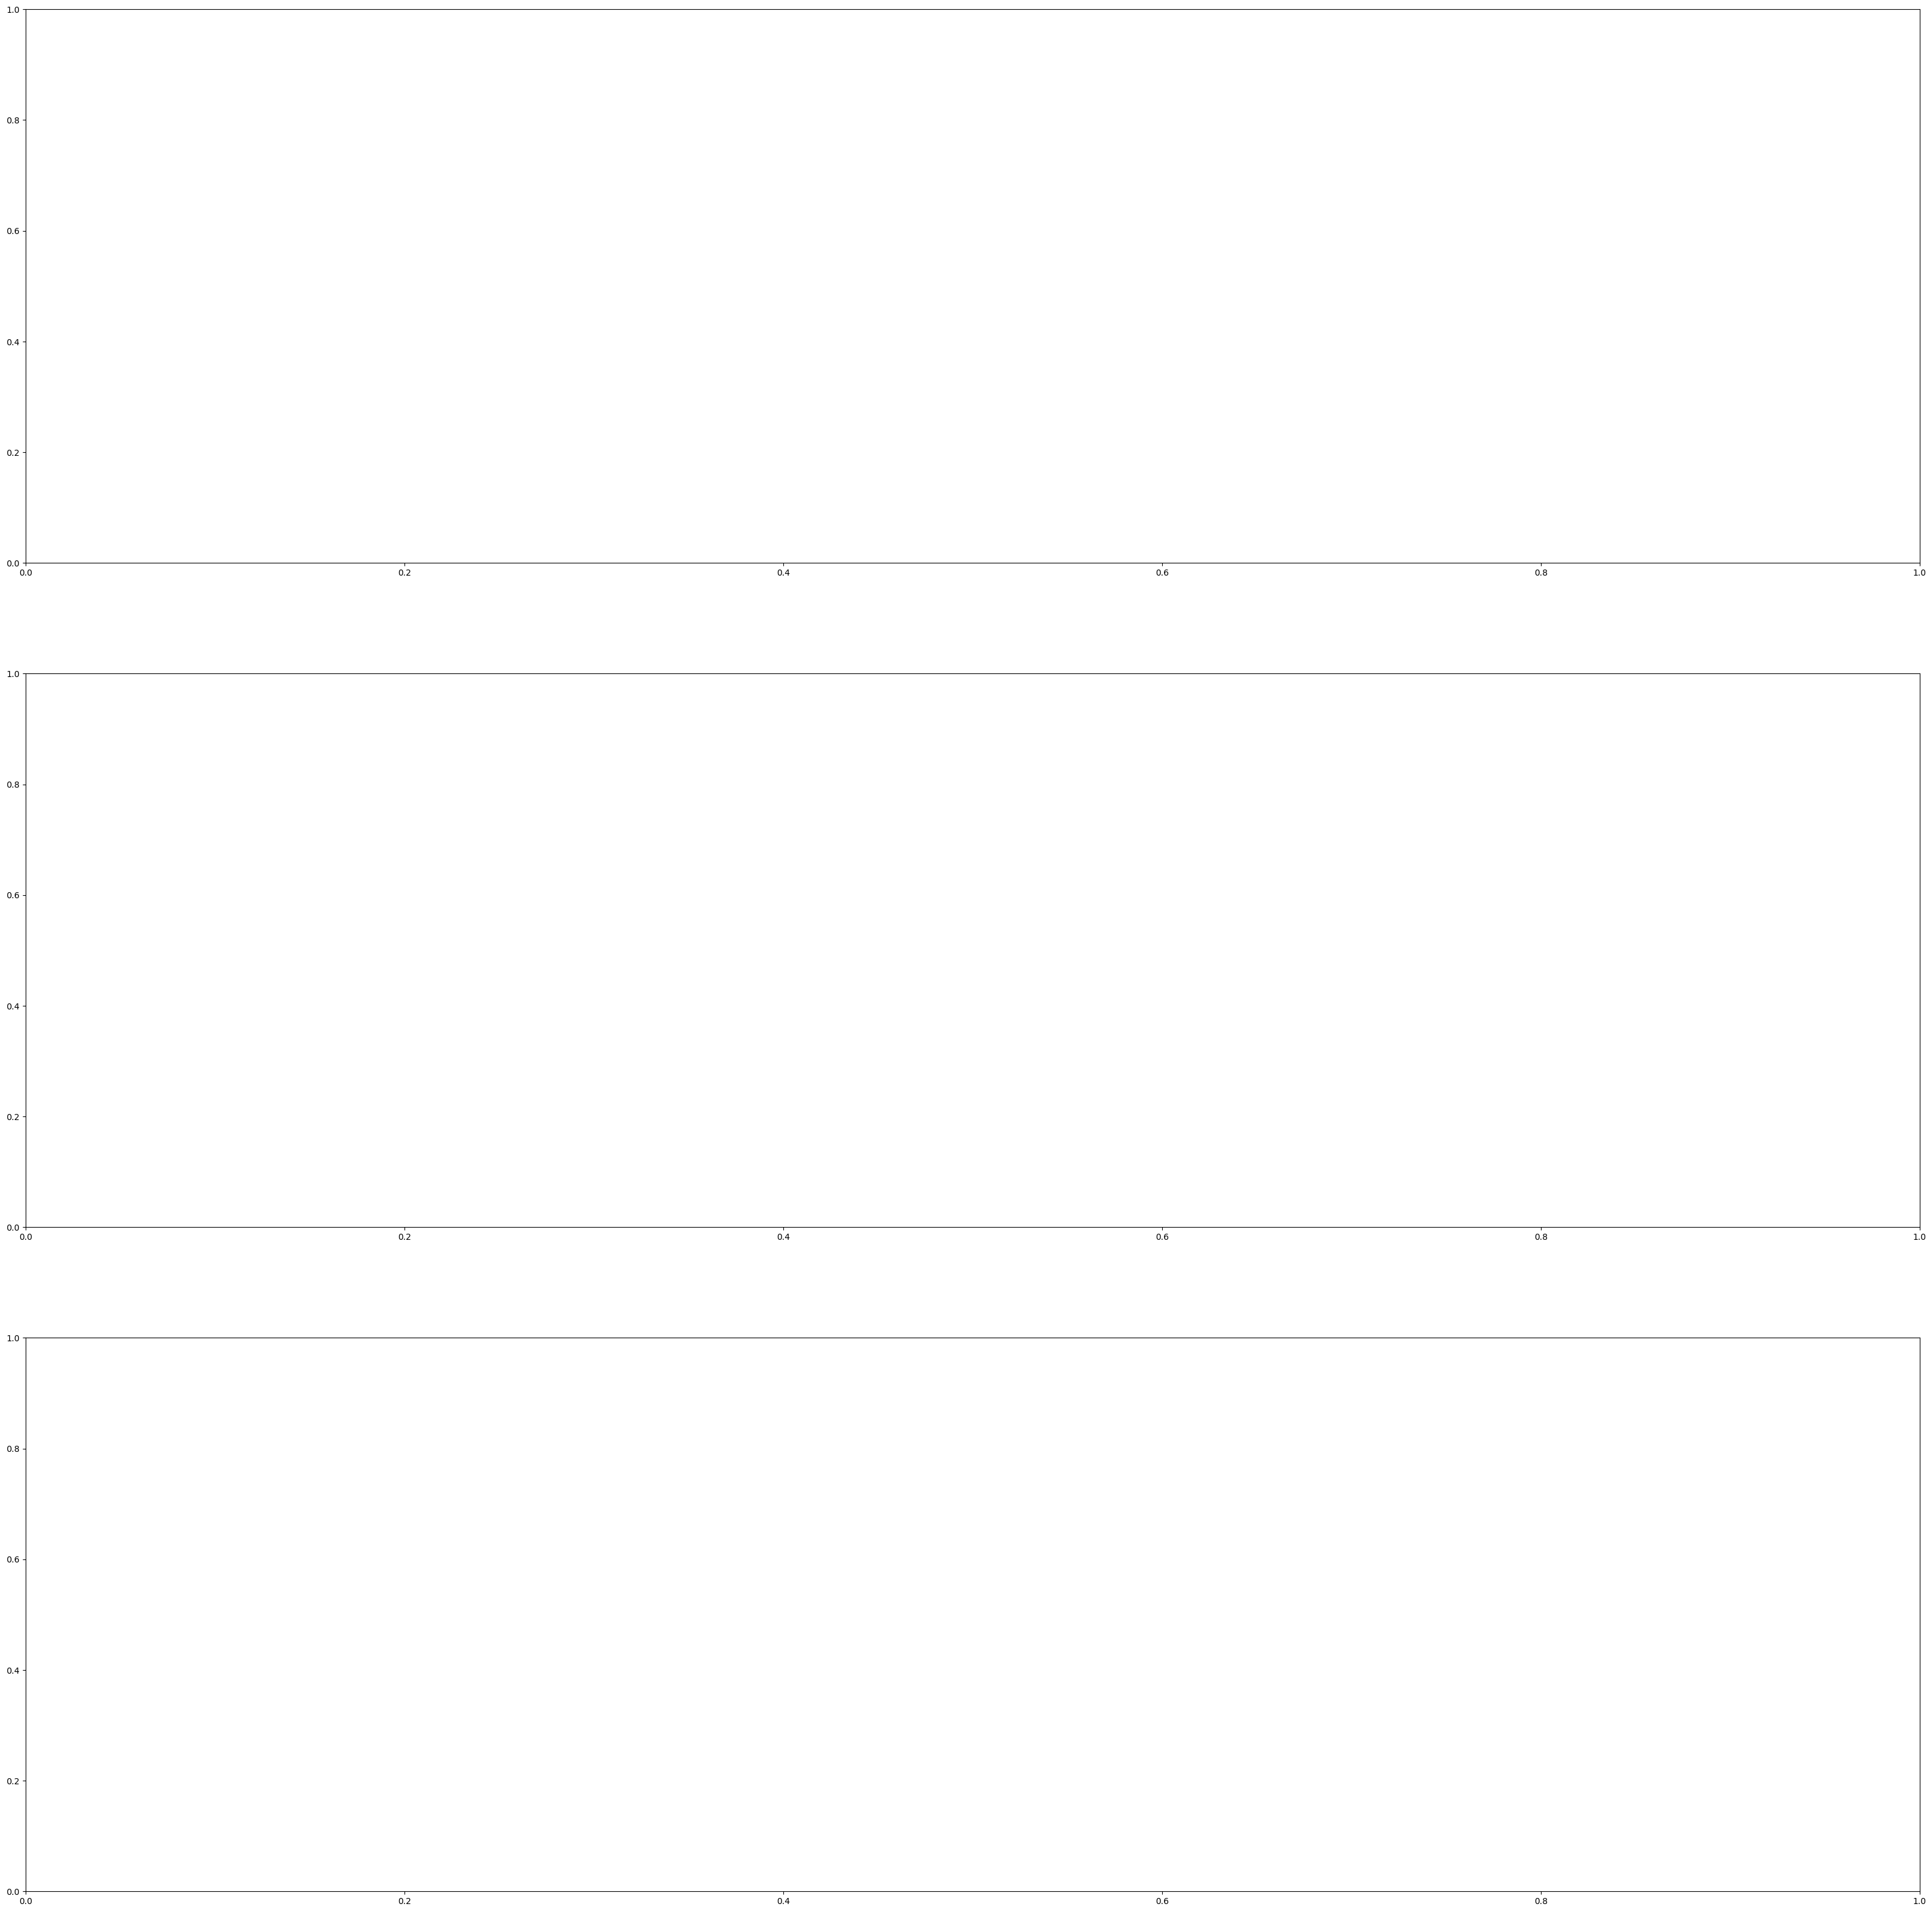

In [160]:
# Create a list of x-axis tick positions
num_ticks = 50  # Adjust this number as needed
x_tick_positions = df_merged['date'].iloc[::len(df_merged) // num_ticks].tolist()

y = 0

fig, axs = plt.subplots(3, 1, figsize=(40, 40))
axs[0].plot(df_merged['date'], df_merged[f'{Body}_tone'], color='blue', label='Net Tone')
axs[1].plot(df_merged['date'], df_merged[f'{Body_2}_tone'], color='red', label='Net Tone')
axs[0].hlines(y, df_merged['date'].min(), df_merged['date'].max(), color='black', label='Zero')
axs[1].hlines(y, df_merged['date'].min(), df_merged['date'].max(), color='black', label='Zero')

axs[2].plot(df_merged['date'], df_merged['net_diff_tone'], color='green', label='Net Sentiment')
axs[2].hlines(y, df_merged['date'].min(), df_merged['date'].max(), color='black', label='Zero')
# Set x-axis ticks for both subplots
axs[0].set_xticks(x_tick_positions)
axs[1].set_xticks(x_tick_positions)
axs[2].set_xticks(x_tick_positions)

axs[0].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='x', rotation=45, labelsize=15)
axs[2].tick_params(axis='x', rotation=45, labelsize=15)

axs[1].set_yticks(np.arange(-1, 1, .1))
axs[0].set_yticks(np.arange(-1, 1, .1))
axs[2].set_yticks(np.arange(-1, 1, .1))

axs[0].set_ylabel(f'{Body} Tone Sentiment', fontsize=20)
axs[1].set_ylabel(f'{Body_2} Tone Sentiment', fontsize=20)
axs[2].set_ylabel(f'Net Tone Sentiment', fontsize=20)

plt.show()

In [ ]:
print(len(df_merged))
df_merged.to_csv(f"{Sentiment_models}/{Body}_{Model}_vs_{Body_2}_{Model_2}_advanced_sentiment_texts.csv", index=False)
print(f"{Sentiment_models}/{Body}_{Model}_vs_{Body_2}_{Model_2}_advanced_sentiment_texts.csv")

289
/Users/kylenabors/Documents/Database/Models/Sentiment Analysis Models/Fed_Speeches_vs_ECB_Speeches_advanced_sentiment_texts.csv
